# MIA attacks on Length-of-Stay predictor, Logistic Regression
## Installation of Packages in Conda

To install the required packages in your conda environment, you can use the following commands:

```bash
conda install h5py
conda install pytables


In [1]:
import os
import sys

project_root = os.path.abspath(os.path.join(os.getcwd(), "../../../"))  # adjust as needed
if project_root not in sys.path:
    sys.path.insert(0, project_root)  # insert at the front to prioritize it


## Train the classifier
For the LR, the data should be flatten. So set the value to True for the LR model anb False for the GRU-D

### Load the dataset
The dataset is generated by the notebook file ....

In [2]:
import os
import yaml
import pickle

# Load the config.yaml file
with open("train_config.yaml", "r") as file:
    train_config = yaml.safe_load(file)

# Determine training method and paths
use_LR = train_config['train']['training_method'] == 'LR'
data_path = train_config['data']['data_dir']
path = os.path.join(data_path, "LR_data" if use_LR else "GRUD_data")

# File paths
dataset_path = os.path.join(path, "dataset.pkl")
indices_path = os.path.join(path, "indices.pkl")

# Load dataset and indices
if os.path.exists(dataset_path) and os.path.exists(indices_path):
    print("Loading dataset...")
    
    with open(dataset_path, "rb") as f:
        dataset = pickle.load(f)

    with open(indices_path, "rb") as f:
        indices_dict = pickle.load(f)
        train_indices = indices_dict["train_indices"]
        test_indices = indices_dict["test_indices"]
        early_stop_indices = indices_dict["early_stop_indices"]
        #TODO: fix this
        data_indices = train_indices + test_indices + early_stop_indices

    print(f"Loaded dataset and indices from {path}")
else:
    print("Dataset not found.\n→ Run 'mimic_dataset_prep.ipynb' to generate the required dataset.\n")


Loading dataset...
Loaded dataset and indices from ./data/LR_data


Create dala loaders.

In [3]:
from torch.utils.data import DataLoader
from mimic_data_handler import MIMICUserDataset


data = dataset.data
targets = dataset.targets

train_subset = MIMICUserDataset(data[train_indices], targets[train_indices])
test_subset = MIMICUserDataset(data[test_indices], targets[test_indices])
early_stop_subset = MIMICUserDataset(data[early_stop_indices], targets[early_stop_indices])

# Create DataLoaders
batch_size = train_config['data']['batch_size']
train_loader = DataLoader(train_subset, batch_size=batch_size)
test_loader = DataLoader(test_subset, batch_size=batch_size)
early_stop_loader = DataLoader(early_stop_subset, batch_size=batch_size)


lr  = 0,0001 for LR - weight_decay = 5.392, epochs = 20

In [4]:
if use_LR:
    from target_model_class import LR
    from torch import  nn, optim, save
    from mimic_LR_handler import MIMICLRHandler


    # Create model
    n_features = train_subset.data.shape[1]
    print(f"Number of features: {n_features}")
    model = LR(input_dim = n_features)

    # Read parameters from config file
    lr = train_config['train']['LR']['learning_rate']
    weight_decay = train_config['train']['LR']['weight_decay']
    epochs = train_config['train']['LR']['epochs']

    # Create optimizer
    criterion = nn.BCELoss()
    optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=weight_decay)

    # Train the model
    train_results = MIMICLRHandler().train(train_loader, model, criterion, optimizer, epochs)
    
    # Evaluate the model
    test_results = MIMICLRHandler().eval(test_loader, model, criterion)

    # Store model and its metadata
    model = train_results.model
    model.to("cpu")
    target_dir = "target_LR"
    os.makedirs(target_dir, exist_ok=True)
    with open(target_dir+"/target_model.pkl", "wb") as f:
        save(model.state_dict(), f)

    # Create metadata to be used by LeakPro
    from leakpro import LeakPro
    meta_data = LeakPro.make_mia_metadata(train_result = train_results,
                                        optimizer = optimizer,
                                        loss_fn = criterion,
                                        dataloader = train_loader,
                                        test_result = test_results,
                                        epochs = epochs,
                                        train_indices = train_indices,
                                        test_indices = test_indices,
                                        dataset_name = train_config["data"]["dataset"])

    with open(target_dir + "/model_metadata.pkl", "wb") as f:
        pickle.dump(meta_data, f)
    






/home/fazeleh/miniconda3/envs/leakpro_py311/lib/python3.11/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/home/fazeleh/miniconda3/envs/leakpro_py311/lib/python3.11/site-packages/torchvision/image.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


Number of features: 7488


Epoch 10/10: 100%|██████████| 94/94 [00:00<00:00, 479.79it/s]


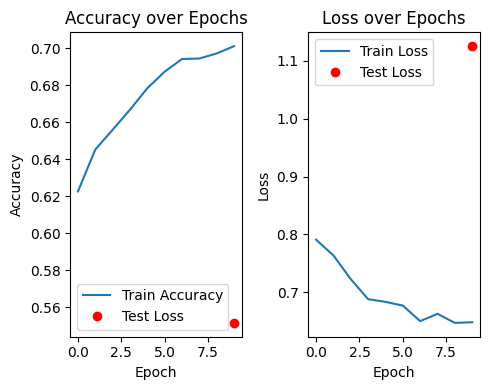

In [5]:
import matplotlib.pyplot as plt

train_acc = train_results.metrics.extra["accuracy_history"]
train_loss = train_results.metrics.extra["loss_history"]
test_acc = test_results.accuracy
test_loss = test_results.loss

# Plot training and test accuracy
plt.figure(figsize=(5, 4))

plt.subplot(1, 2, 1)
plt.plot(train_acc, label='Train Accuracy')
plt.plot(len(train_loss)-1, test_acc, 'ro', label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy over Epochs')
plt.legend()

# Plot training and test loss
plt.subplot(1, 2, 2)
plt.plot(train_loss, label='Train Loss')
plt.plot(len(train_loss)-1, test_loss, 'ro', label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.legend()

plt.tight_layout()
plt.show()

## Attack the LR model
Modify ```audit.yaml ``` file to attack LR model: 
  
  ```
  module_path: "utils/model_LR.py" 
  model_class: "LR"
  target_folder: "./target_LR"
  data_path: "./data/LR_data/dataset.pkl"
  ```


In [ ]:
import os
import sys

project_root = os.path.abspath(os.path.join(os.getcwd(), "../../../"))  # adjust as needed
if project_root not in sys.path:
    sys.path.insert(0, project_root)  # insert at the front to prioritize it
# Read the config file
config_path = "audit.yaml"
from leakpro import LeakPro
if True:
    from mimic_lr_handler import MIMICLRHandler as InputHandler
else:
    from mimic_grud_handler import MIMICGRUDHandler as InputHandler

dataset = InputHandler.UserDataset(data_tensor, y_tensor)


# Instantiate leakpro object
leakpro = LeakPro(MIMICInputHandler, config_path)

# Run the audit 
mia_results = leakpro.run_audit(return_results=True)

In [ ]:
from mimic_LR_handler import MimicInputHandler

from leakpro import LeakPro

# Read the config file
config_path = "audit.yaml"

# Prepare leakpro object
leakpro = LeakPro(MimicInputHandler, config_path)

# Run the audit
mia_results = leakpro.run_audit(return_results=True)

## Generate report

In [ ]:
# Import and initialize ReportHandler
from leakpro.reporting.report_handler import ReportHandler

# report_handler = ReportHandler()
report_handler = ReportHandler(report_dir="./leakpro_output/results")

# Save MIA resuls using report handler
for res in mia_results:
    report_handler.save_results(attack_name=res.attack_name, result_data=res, config=res.configs)

# # Create the report by compiling the latex text
report_handler.create_report()